<a href="https://colab.research.google.com/github/antaripg/deep-learning-notebooks/blob/main/LeNet_W_CIFAR_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive/", force_remount=True)

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision

import copy
import time

In [ ]:
apply_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
batch_size = 100

train_set = datasets.CIFAR10(root='./CIFAR10', train=True, download=True,
                          transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=1)

test_set = datasets.CIFAR10(root='./CIFAR10', train=False, download=True,
                          transform=apply_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [ ]:
img = next(iter(train_loader))
img[0].shape

torch.Size([100, 3, 32, 32])

In [ ]:
img = next(iter(train_loader))
plt.imshow(img[0][0].reshape(32,32,3))

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, 400) # 16 x 5 x 5
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1) # multi-class classification

In [ ]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Copying initial weights
init_weight_conv1 = copy.deepcopy(net.conv1.weight.data)
init_weight_conv2 = copy.deepcopy(net.conv2.weight.data)

In [ ]:
# check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
  print('GPU is available')
  device = 'cuda'
  print('We are running on: '+str(device))
else:
  print('GPU is not available')
  device = 'cpu'
  print('We are running on: '+str(device))
net = net.to(device)

GPU is available
We are running on: cuda


In [ ]:
# defining loss function and optimizer

criterion = nn.NLLLoss() # negative log-likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-4) # Adam optimizers

In [ ]:
# Train the network

iterations = 10
train_loss = []
test_acc = []
start = time.time()

for epoch in range(iterations):
  epoch_start = time.time()
  running_loss  = 0
  net.train() # For training

  for i, data in enumerate(train_loader):
    inputs, labels  = data
    # Wrap them in a Variable
    inputs, labels = inputs.to(device), labels.to(device)
    # Initialize gradients to zero
    optimizer.zero_grad()
    # Feed-forward input data through the network
    outputs = net(inputs)
    # loss calculations
    loss = criterion(outputs, labels)
    # backpropagate loss and compute gradients
    loss.backward()
    # update th network parameters
    optimizer.step()
    # Accumulate loss per batch
    running_loss += loss.item()
  # Average training loss
  average_train_loss = running_loss/(i+1)
  train_loss.append(average_train_loss)

  # Evaluating performance at end of each epoch
  net.eval() # for testing [affects of batch-norm/dropout layers are not considered]
  running_correct = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      inputs = inputs.to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      if use_gpu:
        predicted = predicted.cpu()
      running_correct += (predicted == labels).sum()
  average_test_acc = running_correct/10000.0
  test_acc.append(average_test_acc)

  # Plotting training loss  vs Epochs

  fig1 = plt.figure(1)
  plt.plot(range(epoch+1), train_loss, 'r--', label='train')
  if epoch == 0:
    plt.legend(loc = 'upper left')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')

  # Plotting testing accuracy vs Epochs

  fig2 = plt.figure(2)
  plt.plot(range(epoch+1), test_acc, 'g--', label = 'test')
  if epoch == 0:
    plt.legend(loc = 'upper left')
    plt.xlabel('Epochs')
    plt.ylabel('Testing accuracy')
  epoch_end = time.time() - epoch_start
  print('Iteration: {:.0f}/{:.0f}; Training loss: {:.6f}; Testing Accuracy: {:.6f};Time consumed: {:.0f}m {:.0f}s'
        .format(epoch+1, iterations,average_train_loss, average_test_acc*100,
                epoch_end//60,epoch_end%60))
end = time.time() - start
print('Training completed in {:.0f}m {:0f}s'.format(end//60, end%60))

In [ ]:
img = next(iter(test_loader))
image = img[0]

In [ ]:
predictions = []
net.eval()
running_correct = 0
with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      inputs = inputs.to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      if use_gpu:
        predicted = predicted.cpu()
      predictions.append(predicted)
print(len(predictions))

100


In [ ]:
predictions[0]

In [ ]:
# Copying the trained weights for visualization
trained_weight_conv1 = copy.deepcopy(net.conv1.weight.data)
trained_weight_conv2 = copy.deepcopy(net.conv2.weight.data)

In [ ]:
# functions to show an image
def imshow(img, strlabel):
  np_img = img.numpy()
  np_img = np.abs(np_img)
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 10
  fig_size[1] = 10
  plt.rcParams["figure.figsize"] = fig_size
  plt.figure()
  plt.title(strlabel)
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

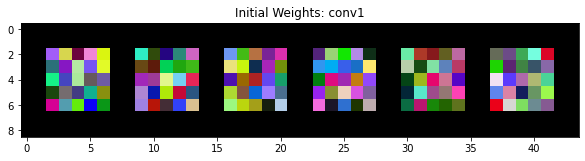

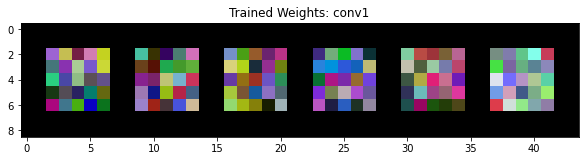

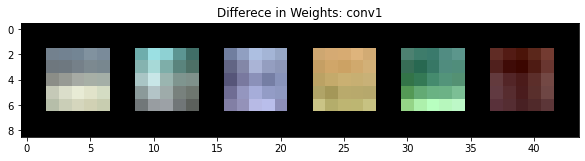

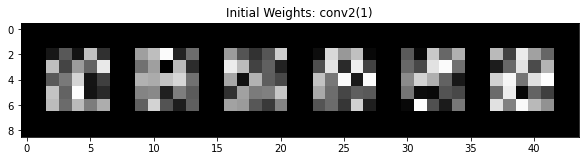

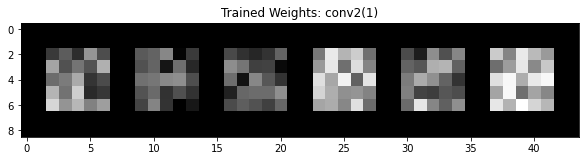

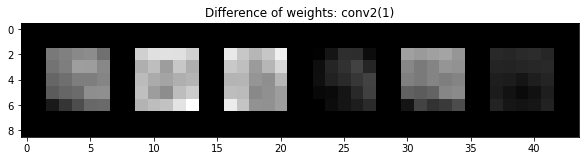

In [ ]:
if use_gpu:
  trained_weight_conv1 = trained_weight_conv1.cpu()
  trained_weight_conv2 = trained_weight_conv2.cpu()

# Visualizing all the kernels weights: their initial, trained and diff
imshow(torchvision.utils.make_grid(init_weight_conv1, nrow=6, normalize=True), 'Initial Weights: conv1')
imshow(torchvision.utils.make_grid(trained_weight_conv1, nrow=6, normalize=True), 'Trained Weights: conv1')
imshow(torchvision.utils.make_grid(init_weight_conv1 - trained_weight_conv1, nrow=6, normalize=True),
       'Differece in Weights: conv1')
# Visualizing one of the kernels in conv2 layer weights: initial, trained and diff
imshow(torchvision.utils.make_grid(init_weight_conv2[0].unsqueeze(1),nrow=6,normalize=True),'Initial Weights: conv2(1)')
imshow(torchvision.utils.make_grid(trained_weight_conv2[0].unsqueeze(1),nrow=6,normalize=True),'Trained Weights: conv2(1)')
imshow(torchvision.utils.make_grid(init_weight_conv2[0].unsqueeze(1)-trained_weight_conv2[0].unsqueeze(1),nrow=6,normalize=True),'Difference of weights: conv2(1)')
